In [1]:
import os
import numpy as np
import numpy.ma as ma
from astropy.table import Table
from scipy.optimize import minimize, Bounds
from DRP_rotation_curve import extract_data, extract_Pipe3d_data
from disk_mass import calc_mass_curve, fit_mass_curve
from rotation_fitfunctions import find_phi, parameterfit_iso, parameterfit_NFW, parameterfit_bur, rot_incl_iso, rot_incl_bur, \
rot_incl_NFW
from rotation_curve_functions import disk_bulge_vel
from RC_plotting_functions import plot_diagnostic_panel
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
gal_ID = '7443-12705'
H_0 = 100  # Hubble's Constant in units of h km/s/Mpc
c = 299792.458  # Speed of light in units of km/s
fit_function = 'bulge'


In [3]:
MASS_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\pipe3d\v3_1_1\3.1.1\7443"
VEL_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\analysis\v3_1_1\3.1.0\HYB10-MILESHC-MASTARSSP\7443\12705"
DRP_FILENAME = r"C:\Users\Lara\Documents\rotationcurves\mangadata\redux\v3_1_1\drpall-v3_1_1.fits"

In [4]:
DRP_FILENAME = r"C:\Users\Lara\Documents\rotationcurves\mangadata\redux\v3_1_1\drpall-v3_1_1.fits"
DRP_table = Table.read( DRP_FILENAME, format='fits')


DRP_index = {}

for i in range(len(DRP_table)):
    galaxy_ID = DRP_table['plateifu'][i]

    DRP_index[galaxy_ID] = i


In [5]:
maps = extract_data(VEL_MAP_FOLDER,gal_ID,['Ha_vel', 'r_band', 'Ha_flux', 'Ha_sigma'])
sMass_density, sMass_density_err = extract_Pipe3d_data(MASS_MAP_FOLDER, gal_ID)
i_DRP = DRP_index[gal_ID]
axis_ratio = DRP_table['nsa_elpetro_ba'][i_DRP]
incl = np.arccos(axis_ratio)
phi = DRP_table['nsa_elpetro_phi'][i_DRP]
print("nsa",phi)
z = DRP_table['nsa_z'][i_DRP]
map_mask = maps['Ha_vel_mask']

maps['vmasked'] = ma.array(maps['Ha_vel'], mask=map_mask)
maps['ivarmasked'] = ma.array(maps['Ha_vel_ivar'], mask=map_mask)

shape = maps['vmasked'].shape
scale = (0.5 * z * c / H_0) * 1000 / 206265  # kpc
center = np.unravel_index(ma.argmax(maps['r_band']), shape)
x_center = center[0]
y_center = center[1]
count = 0
phi = find_phi(center, phi, maps['vmasked'])
print("find_phi",phi*180/np.pi)
print(incl)

nsa 36.9388
-9.503156
(37, 37)
0.6447036817356814
find_phi 36.9388
1.068397871682945


finding mass curve
7443-12705 mass curve calculated


C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:380: RuntimeWarning: invalid value encountered in multiply
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:389: RuntimeWarning: invalid value encountered in true_divide
  vb_2 = coeff_2 * F / r
C:\Users\Lara\Documents\rotationcurves\disk_mass_plotting_functions.py:89: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[fit_parameters['Sigma_disk'],
C:\Users\Lara\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


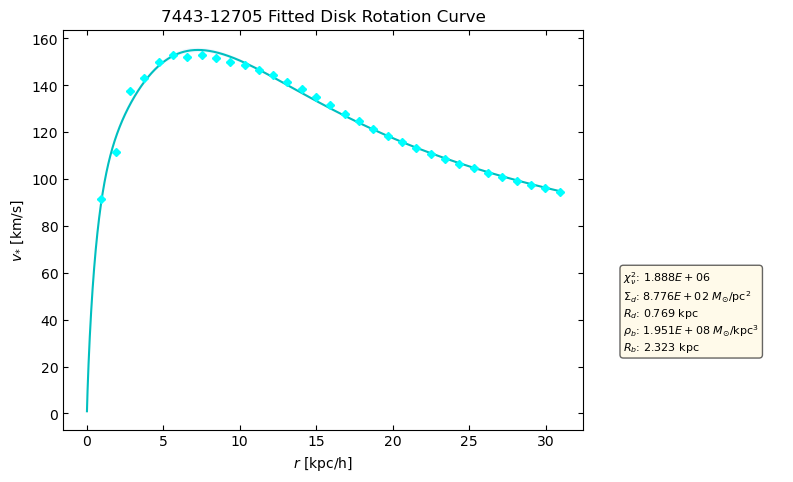

{'Sigma_disk': 877.5968281404483, 'Sigma_disk_err': 50.664696522098446, 'R_disk': 0.7689406307205499, 'R_disk_err': 0.06868850585621009, 'rho_bulge': 195061856.85765797, 'rho_bulge_err': 11939204.49324219, 'R_bulge': 2.323128917886229, 'R_bulge_err': 0.045234162063295294, 'chi2_disk': 1888354.5213263303}


In [8]:
mass_data_table = calc_mass_curve(sMass_density,
                                          sMass_density_err,
                                          maps['r_band'],
                                          map_mask,
                                          x_center,
                                          y_center,
                                          axis_ratio,
                                          phi,
                                          z,
                                          gal_ID)
print(gal_ID, "mass curve calculated")
param_outputs = fit_mass_curve(mass_data_table,
                                       gal_ID,
                                       fit_function)
print(param_outputs)


In [9]:
param = [incl, phi, x_center, y_center]

In [10]:
best_fit_NFW = parameterfit_NFW(param, param_outputs['rho_bulge'], param_outputs['R_bulge'],
                                        param_outputs['Sigma_disk'], param_outputs['R_disk'], scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)


C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:222: RuntimeWarning: invalid value encountered in double_scalars
  vel = np.sqrt(G*(bulge_mass*1.988E30)/(r*3.08E16))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:341: RuntimeWarning: invalid value encountered in double_scalars
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:587: RuntimeWarning: invalid value encountered in double_scalars
  vel2 = G * (halo_mass * Msun) / (r * 3.08E16)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:586: RuntimeWarning: invalid value encountered in log
  halo_mass = 4*np.pi*rho0_h*Rh**3*((-r/(Rh+r)) + np.log(Rh + r) - np.log(Rh))


KeyboardInterrupt: 

In [ ]:
best_fit_bur = parameterfit_bur(param, param_outputs['rho_bulge'], param_outputs['R_bulge'],
                                        param_outputs['Sigma_disk'], param_outputs['R_disk'], scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

In [11]:
best_fit_iso = parameterfit_iso(param, param_outputs['rho_bulge'], param_outputs['R_bulge'],
                                        param_outputs['Sigma_disk'], param_outputs['R_disk'], scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:500: RuntimeWarning: invalid value encountered in sqrt
  vel = v_inf * np.sqrt(1 - ((Rh/r)*np.arctan2(Rh,r)))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:500: RuntimeWarning: divide by zero encountered in double_scalars
  vel = v_inf * np.sqrt(1 - ((Rh/r)*np.arctan2(Rh,r)))


KeyboardInterrupt: 

In [ ]:
iso_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_bur[0],best_fit_bur[1],best_fit_bur[2],best_fit_bur[3],best_fit_bur[4],best_fit_bur[5],best_fit_bur[6]]
NFW_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_bur[0],best_fit_bur[1],best_fit_bur[2],best_fit_bur[3],best_fit_bur[4],best_fit_bur[5],best_fit_bur[6]]
bur_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_bur[0],best_fit_bur[1],best_fit_bur[2],best_fit_bur[3],best_fit_bur[4],best_fit_bur[5],best_fit_bur[6]]

Text(0.5, 1.0, '7443-12705 data')

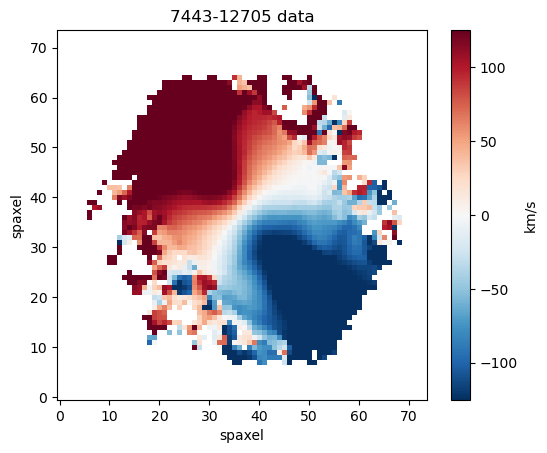

In [7]:
plt.imshow(maps['vmasked'], 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-125, 
           vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')
plt.title('7443-12705 data')

In [ ]:
plot_diagnostic_panel(gal_ID, shape, scale, iso_fit, NFW_fit, bur_fit, map_mask, maps['vmasked'],maps['ivarmasked'])
plt.savefig(r"C:\Users\Lara\Documents\rotationcurves\7443-12705_diagnostic")